In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Input
# from tensorflow.keras.layers import Concatenate
# from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Figure out how partial derivatives and gradients work
# def f(x):
#     return tf.math.square(x[0]) + tf.math.square(x[1]) + tf.math.multiply(x[0],x[1]) # x^2+y^2+xy

# x_bar = tf.Variable([[1.0,2,3,4],[1,1,1,1]]) # x_bar = (x,y)
# print(x[0])
# with tf.GradientTape() as t:
#     t.watch(x_bar)
#     f = f(x_bar)
# grad_f = t.gradient(f,x_bar)
# df_dx = grad_f[0]
# df_dy = grad_f[1]
# print(grad_f, df_dx, df_dy)
# a = tf.constant([[1, 2, 3, 4],[1,2,3,4]])
# b = tf.constant([1, 1, 1, 1])
# d = tf.constant([2,2,2,2])
# c = tf.subtract(a,b)
# c = tf.stack([a,b,d])
# print(c)
# c = tf.squeeze(c)
# print(c)

In [21]:
# Construct model
model = Sequential()
model.add(Dense(100, input_shape=[2,], activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(1))

In [49]:
def loss_fn(model, theta_out): # loss_fn(model, [x,y], [theta_in], [theta_out])

# Find loss for outer boundary points #####################################################################    
    x_out = tf.math.scalar_mul(4, tf.math.cos(theta_out)) # x = 4cos(theta_in)
    y_out = tf.math.scalar_mul(4, tf.math.sin(theta_out)) # y = 4sin(theta_in)
    out_bnd_pts = tf.transpose(tf.stack([x_out,y_out],0))
    
    y_true =  tf.math.scalar_mul(4, tf.math.sin(tf.math.scalar_mul(5, theta_out)))                                 
    y_pred = model(out_bnd_pts) # out_bnd_err = g(x,y)-4sin(5theta)
                                  
    loss = tf.keras.metrics.mean_squared_error(y_true,y_pred) # MSE outer bound points / 2

    return loss

In [71]:
# Train network
def train_for():

# Define training parameters ##############################################################################    
    optimizer = tf.keras.optimizers.Nadam() # Fancy gradient decent
    epochs = 20
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    theta_out_size = 100 # Number of outer boundary points to sample each iteration

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
    
# Sample outer bound thetas ###############################################################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                loss = loss_fn(model, theta_out) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            #optimizer.minimize(loss_fn(model, theta_out), model.trainable_weights)
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 1 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [72]:
train_for()

Epoch 000: Loss: 7.966
Epoch 001: Loss: 8.036
Epoch 002: Loss: 8.004
Epoch 003: Loss: 7.997
Epoch 004: Loss: 8.005
Epoch 005: Loss: 7.966
Epoch 006: Loss: 7.881
Epoch 007: Loss: 8.026
Epoch 008: Loss: 8.046
Epoch 009: Loss: 8.026
Epoch 010: Loss: 8.118
Epoch 011: Loss: 7.998
Epoch 012: Loss: 7.953
Epoch 013: Loss: 8.005
Epoch 014: Loss: 8.078
Epoch 015: Loss: 7.979
Epoch 016: Loss: 7.878
Epoch 017: Loss: 8.059
Epoch 018: Loss: 7.960
Epoch 019: Loss: 7.949


In [57]:
# Generate test points to plot ############################################################################
out_bnd_pts_size = 1000 # Number of outer boundary points to sample 

# Sample outer boundary points ############################################################################
theta_out = tf.random.uniform([1, out_bnd_pts_size], minval=0, maxval=2*np.pi)
x_out = tf.math.scalar_mul(4, tf.math.cos(theta_out))
y_out = tf.math.scalar_mul(4, tf.math.sin(theta_out))
out_bnd_pts = tf.stack([x_out, y_out], 0)
# print(out_bnd_pts.shape)
# print(out_bnd_pts)

test_pts = tf.transpose(out_bnd_pts)
# print(test_pts)
print(test_pts.shape)

z = model(test_pts)
print(tf.shape(z))

(1000, 1, 2)
tf.Tensor([1000    1    1], shape=(3,), dtype=int32)


(1000,)
(1000,)
(1000,)


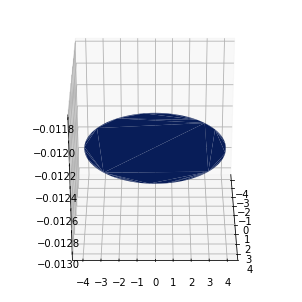

In [58]:
# Plot ####################################################################################################
fig = pylab.figure(figsize=plt.figaspect(1))
ax = Axes3D(fig)

X = test_pts[0:, 0, 0].numpy()
print(X.shape)
Y = test_pts[0:, 0, 1].numpy()
print(Y.shape)
Z = z[0:, 0, 0].numpy()
print(Z.shape)

ax.plot_trisurf(X,Y,Z, cmap=plt.cm.YlGnBu_r)
ax.view_init(30, 0)
plt.show()

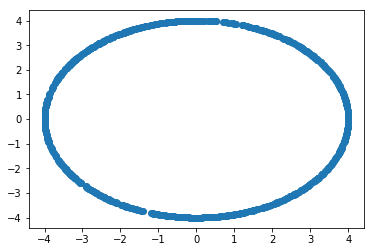

In [59]:
plt.scatter(X,Y)
plt.show()